# Import Statements

In [1]:
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from livelossplot import PlotLossesKeras
from scipy.signal import savgol_filter
from statsmodels.tsa.stattools import adfuller
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Merge, Average, Maximum, Concatenate
from keras.layers.advanced_activations import LeakyReLU, PReLU, ELU, ThresholdedReLU

np.random.seed(101)

Using TensorFlow backend.


# Data Import

In [50]:
df = pd.read_csv("notNiteeshData.csv")
# start = pd.to_datetime(df.index[0])
# end = pd.to_datetime(df.index[-1])
# dd = [start + timedelta(days=x) for x in range((end-start).days + 1)]
# dd = [str(i.date()) for i in dd]
# df = df.reindex(dd)
trunc_df = df[df.columns[list(range(1,7))+list(range(80,94))]]
trunc_df['tot_occ'] = trunc_df['english']+trunc_df['hindi']+trunc_df['tamil']+trunc_df['others']
trunc_df = pd.concat([trunc_df[trunc_df.columns[:5]],trunc_df['tot_occ'],trunc_df[trunc_df.columns[5:-1]]], axis=1)
trunc_df.drop(list(range(360,405)),inplace=True, axis=0)
trunc_df = trunc_df[trunc_df["ES_POPCORN SMALL"]>75]
trunc_df = trunc_df.reset_index()
# trunc_df = trunc_df.fillna(trunc_df.mean())

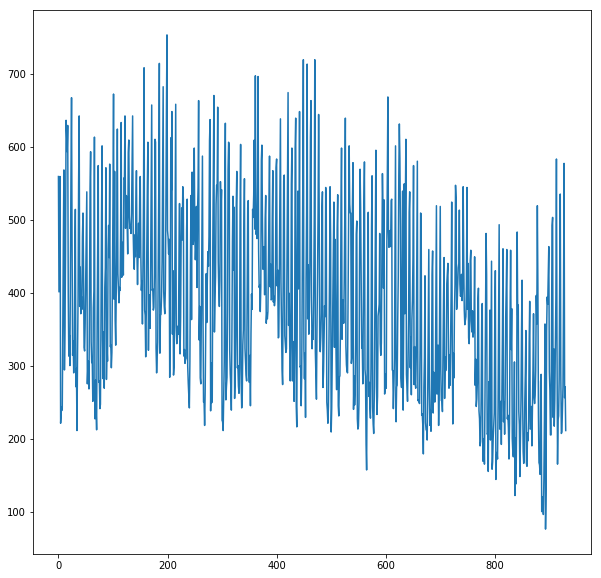

In [52]:
plt.figure(figsize=fig_size)
trunc_df['ES_POPCORN SMALL'].plot()

# Time series analysis tutorial method

In [53]:
fig_size = (10,10)

In [54]:
ts = trunc_df['ES_POPCORN SMALL']
#ts_1 = pd.Series(savgol_filter(ts,31,5), index=ts.index)

In [55]:
def test_stationarity(timeseries):
    
    plt.figure(figsize=fig_size)
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=10)
    rolstd = pd.rolling_std(timeseries, window=10)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

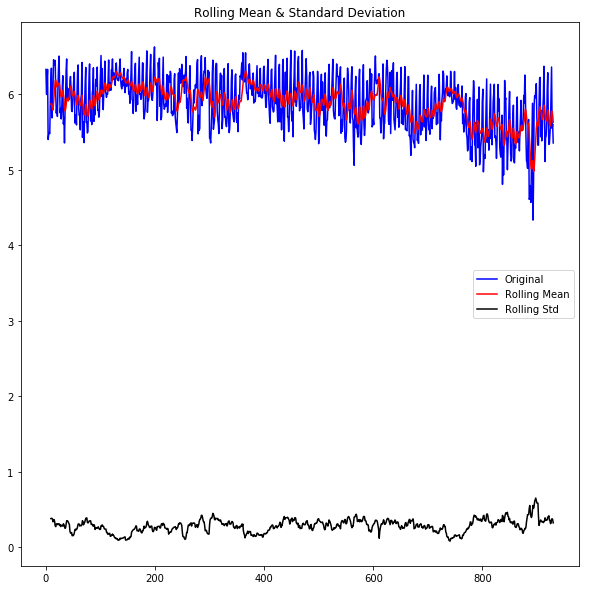

Results of Dickey-Fuller Test:
Test Statistic                  -2.620659
p-value                          0.088802
#Lags Used                      21.000000
Number of Observations Used    909.000000
Critical Value (5%)             -2.864725
Critical Value (10%)            -2.568466
Critical Value (1%)             -3.437564
dtype: float64


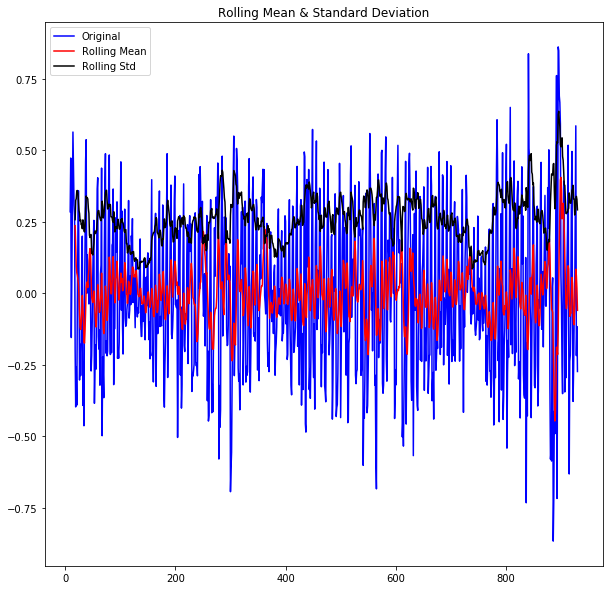

Results of Dickey-Fuller Test:
Test Statistic                -8.457208e+00
p-value                        1.602845e-13
#Lags Used                     2.100000e+01
Number of Observations Used    9.000000e+02
Critical Value (5%)           -2.864757e+00
Critical Value (10%)          -2.568483e+00
Critical Value (1%)           -3.437637e+00
dtype: float64


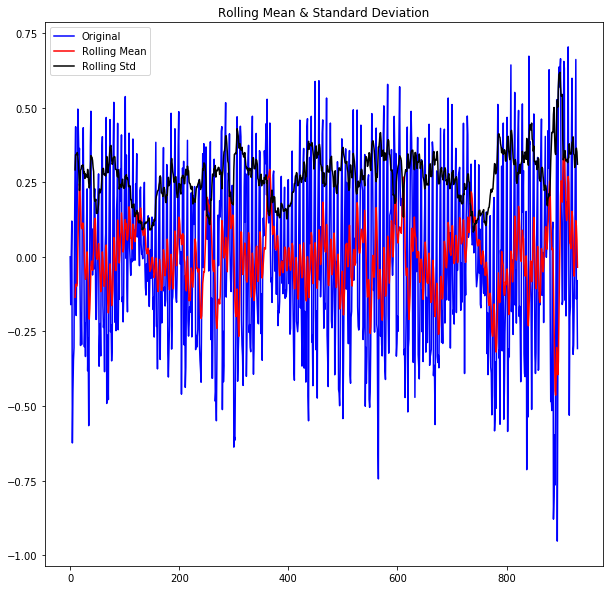

Results of Dickey-Fuller Test:
Test Statistic                -6.271308e+00
p-value                        3.998058e-08
#Lags Used                     2.100000e+01
Number of Observations Used    9.090000e+02
Critical Value (5%)           -2.864725e+00
Critical Value (10%)          -2.568466e+00
Critical Value (1%)           -3.437564e+00
dtype: float64


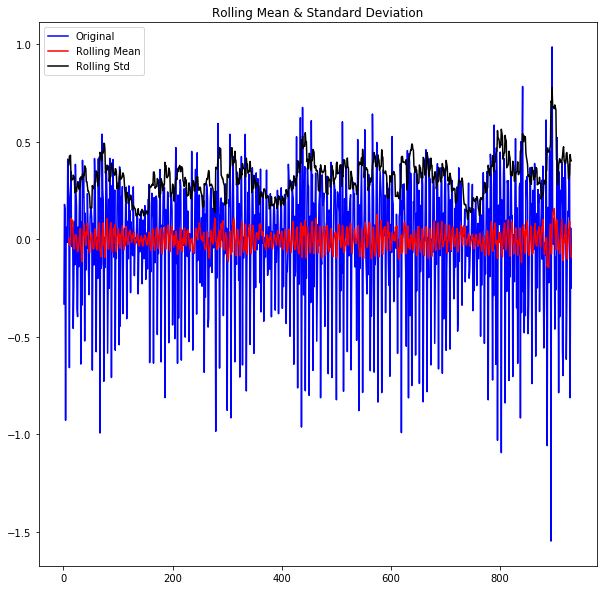

Results of Dickey-Fuller Test:
Test Statistic                -1.030965e+01
p-value                        3.210223e-18
#Lags Used                     2.000000e+01
Number of Observations Used    9.090000e+02
Critical Value (5%)           -2.864725e+00
Critical Value (10%)          -2.568466e+00
Critical Value (1%)           -3.437564e+00
dtype: float64


In [56]:
ts_log = np.log(ts)

moving_avg = pd.rolling_mean(ts_log, 10)
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.dropna(inplace=True)

expwighted_avg = pd.ewma(ts_log, halflife=10)
ts_log_ewma_diff = ts_log - expwighted_avg

ts_log_diff = ts_log - ts_log.shift(1)
ts_log_diff.dropna(inplace=True)

ts_log = ts_log.replace([np.inf, -np.inf, np.nan],6)
ts_log_moving_avg_diff = ts_log_moving_avg_diff.replace([np.inf, -np.inf, np.nan],ts_log_moving_avg_diff.mean())
ts_log_ewma_diff = ts_log_ewma_diff.replace([np.inf, -np.inf, np.nan],0)
ts_log_diff = ts_log_diff.replace([np.inf, -np.inf, np.nan],0)

test_stationarity(ts_log)
test_stationarity(ts_log_moving_avg_diff)
test_stationarity(ts_log_ewma_diff)
test_stationarity(ts_log_diff)

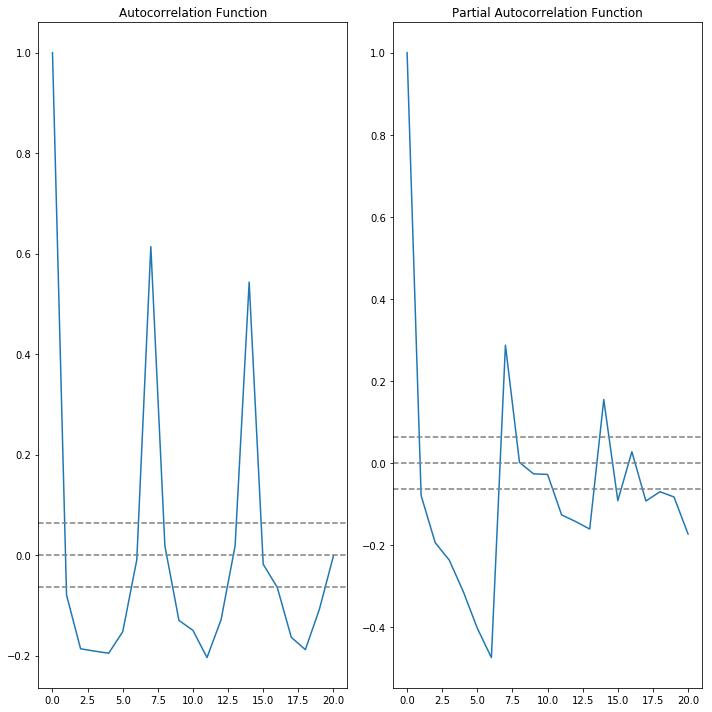

In [57]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

plt.figure(figsize=fig_size)
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# Data manipulation and LSTM

In [58]:
def convert_3d_timesteps(timesteps, data, n_feat):
    for i in range(timesteps):
        data = pd.concat([data,data.iloc[:,-n_feat:].shift(-1)], axis=1)
    x = data.values[:-timesteps,:-n_feat]
    y = data.values[:-timesteps,-1]
    print("Creating x and y")
    return x,y

def data_creation(i, df, l_feat):
    data = df[df.columns[l_feat+[i]]]
    x,y = convert_3d_timesteps(timesteps=time_steps, data=data, n_feat=n_features)
    print("Reshaping x and y")
    x = x.reshape(-1,time_steps,n_features)
    y = y.reshape(-1,1)
    print(x.shape, y.shape)

    x_train = x[:700,:]
    x_test = x[700:,:]
    y_train = y[:700,:]
    y_test = y[700:,:]
    
    return x_train, x_test, y_train, y_test

In [59]:
def model_run(time_steps, n_features, x_train, y_train):
    
    inp = Input(shape=(time_steps,n_features))
    
    x1 = LSTM(25, activity_regularizer='l1')(inp)
    x1 = Dropout(0.2)(x1)
    x1 = Dense(128)(x1)
    x1 = Dropout(0.15)(x1)
    x1 = LeakyReLU(0.3)(x1)
    x1 = Dense(64)(x1)
    x1 = Dropout(0.15)(x1)
    x1 = LeakyReLU(0.3)(x1)
    x1 = Dense(16)(x1)
    x1 = Dropout(0.15)(x1)
    x1 = LeakyReLU(0.3)(x1)
    x1 = Dense(8)(x1)
    x1 = Dropout(0.15)(x1)
    x1 = LeakyReLU(0.3)(x1)
    x1 = Dense(1)(x1)
    x1 = Dropout(0.15)(x1)
    out1 = LeakyReLU(0.3, name='M1')(x1)
    
#     x2 = LSTM(25, activity_regularizer='l1', return_sequences=True)(inp)
#     x2 = Dropout(0.3)(x2)
#     x2 = LSTM(50, activity_regularizer='l1')(x2)
#     x2 = Dropout(0.3)(x2)
# #     x2 = Dense(128)(x2)
# #     x2 = Dropout(0.15)(x2)
# #     x2 = LeakyReLU(0.3)(x2)
# #     x2 = Dense(64)(x2)
# #     x2 = Dropout(0.15)(x2)
# #     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(128)(x2)
#     x2 = Dropout(0.15)(x2)
#     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(64)(x2)
#     x2 = Dropout(0.15)(x2)
#     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(32)(x2)
#     x2 = Dropout(0.15)(x2)
#     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(16)(x2)
#     x2 = Dropout(0.15)(x2)
#     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(8)(x2)
#     x2 = Dropout(0.15)(x2)
#     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(4)(x2)
#     x2 = Dropout(0.15)(x2)
#     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(2)(x2)
#     x2 = Dropout(0.15)(x2)
#     x2 = LeakyReLU(0.3)(x2)
#     x2 = Dense(1)(x2)
#     x2 = Dropout(0.15)(x2)
#     out2 = LeakyReLU(0.3, name='M2')(x2)
    
#     x3 = LSTM(50, activity_regularizer='l1', return_sequences=True)(inp)
#     x3 = Dropout(0.3)(x3)
#     x3 = LSTM(100, activity_regularizer='l1')(x3)
#     x3 = Dropout(0.3)(x3)
#     x3 = Dense(128)(x3)
#     x3 = Dropout(0.15)(x3)
#     x3 = LeakyReLU(0.3)(x3)
#     x3 = Dense(256)(x3)
#     x3 = Dropout(0.15)(x3)
#     x3 = LeakyReLU(0.3)(x3)
#     x3 = Dense(32)(x3)
#     x3 = Dropout(0.15)(x3)
#     x3 = LeakyReLU(0.3)(x3)
#     x3 = Dense(16)(x3)
#     x3 = Dropout(0.15)(x3)
#     x3 = LeakyReLU(0.3)(x3)
#     x3 = Dense(1)(x3)
#     x3 = Dropout(0.15)(x3)
#     out3 = LeakyReLU(0.3, name='M3')(x3)
    
#     x4 = LSTM(100, activity_regularizer='l1', return_sequences=True)(inp)
#     x4 = Dropout(0.3)(x4)
#     x4 = LSTM(50, activity_regularizer='l1', return_sequences=True)(x4)
#     x4 = Dropout(0.3)(x4)
#     x4 = LSTM(25, activity_regularizer='l1')(x4)
#     x4 = Dropout(0.3)(x4)
#     x4 = Dense(128)(x4)
#     x4 = Dropout(0.15)(x4)
#     x4 = LeakyReLU(0.3)(x4)
#     x4 = Dense(64)(x4)
#     x4 = Dropout(0.15)(x4)
#     x4 = LeakyReLU(0.3)(x4)
#     x4 = Dense(32)(x4)
#     x4 = Dropout(0.15)(x4)
#     x4 = LeakyReLU(0.3)(x4)
#     x4 = Dense(8)(x4)
#     x4 = Dropout(0.15)(x4)
#     x4 = LeakyReLU(0.3)(x4)
#     x4 = Dense(1)(x4)
#     x4 = Dropout(0.15)(x4)
#     out4 = LeakyReLU(0.3, name='M4')(x4)
    
    model = Model(inputs=[inp], outputs=[out1], name='LSTM parallels')
    model.summary()
    
    print(x_train.shape, y_train.shape)
    model.compile(optimizer='nadam', loss='mean_squared_error', metrics=['mae'])
    model.fit(x_train, y_train, callbacks=[PlotLossesKeras()], verbose=0, batch_size=50, epochs=100, validation_data=(x_test,y_test))
    
    return model

In [60]:
def error_counting(y_pred, y_test):
    error_counts = [0,0,0,0,0]
    for i in range(len(y_pred)):
        err = 100*np.abs(y_test[i] - y_pred[i])/y_test[i]
        if(err < 10):
            error_counts[0]+=1
        elif(err <20):
            error_counts[1]+=1
        elif(err <30):
            error_counts[2]+=1
        elif(err <40):
            error_counts[3]+=1
        elif(err >= 40):
            error_counts[4]+=1
    print("--------------")
    print(error_counts)

# Model runs

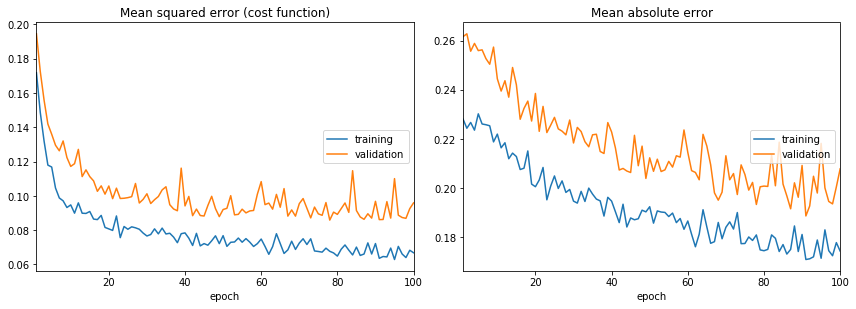

220/220 [==============================] - 0s 227us/step
[0.09240253337404945, 0.20782896199009634]


In [62]:
model = model_run(time_steps=time_steps, n_features=n_features, x_train=x_train, y_train=y_train)
scores = model.evaluate(x_test, y_test, batch_size=32)
y_pred = model.predict(x_test)
print(scores)

0   -0.235711
1   -0.265892
2   -0.400331
3   -0.516051
4   -0.568949
5   -0.577768
6   -0.641744
7   -0.938187
8   -0.952129
9   -0.908254
dtype: float32 [[-0.23571122]
 [-0.03018055]
 [-0.13443895]
 [-0.11571999]
 [-0.05289816]
 [-0.00881876]
 [-0.06397687]
 [-0.296443  ]
 [-0.01394202]
 [ 0.04387562]]


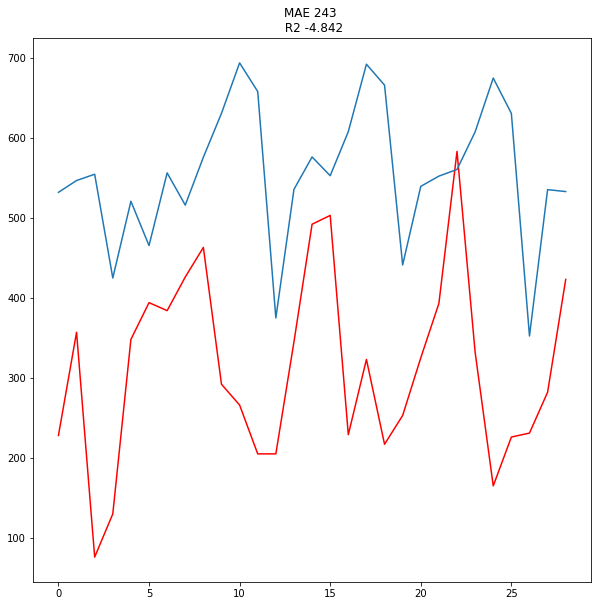

In [74]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(x)

t = y_pred.flatten()

cum_sum = pd.Series(t).cumsum()

cum_sum1 = t + ts_log[0]

cum_sum1 = np.exp(cum_sum1)

print(cum_sum[:10], y_pred[:10])

plt.figure(figsize=fig_size)
plt.title("MAE %.f \n R2 %.3f"%(mean_absolute_error(ts.values[-40:-11], cum_sum1[-29:]), r2_score(ts.values[-40:-11], cum_sum1[-29:])))
plt.plot(ts.values[-40:-11], color='r')
plt.plot(cum_sum1[-29:])
plt.show()